In [1]:
import os
from helper_functions import *

db_file = os.path.abspath("db.json")

Found many potential paths for FW_CONFIG_FILE: [u'/home/matk/.fireworks/FW_config.yaml', '/home/matk/Software/eg_dev/config/fw/FW_config.yaml']
Choosing as default: /home/matk/.fireworks/FW_config.yaml


In [2]:
from pymatgen.util.testing import PymatgenTest

struct_si = PymatgenTest.get_structure("Si")
print struct_si

Full Formula (Si2)
Reduced Formula: Si
abc   :   3.840198   3.840199   3.840198
angles: 119.999991  90.000000  60.000009
Sites (2)
  #  SP       a    b     c
---  ----  ----  ---  ----
  0  Si    0     0    0
  1  Si    0.75  0.5  0.75


In [3]:
from pymatgen.io.vasp.sets import MPRelaxSet

vis = MPRelaxSet(struct_si, force_gamma=True)

In [4]:
from matmethods.vasp.fireworks.core import OptimizeFW

fw1 = OptimizeFW(struct_si, vasp_input_set=vis, vasp_cmd=None, db_file=db_file)

for task in fw1.tasks:
    print task.fw_name

{{matmethods.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}
{{matmethods.vasp.firetasks.run_calc.RunVaspCustodian}}
{{matmethods.common.firetasks.glue_tasks.PassCalcLocs}}
{{matmethods.vasp.firetasks.parse_outputs.VaspToDbTask}}


In [5]:
from matmethods.vasp.fireworks.core import StaticFW

fw2 = StaticFW(struct_si, vasp_input_set=vis, vasp_cmd=None, db_file=db_file, 
               parents=[fw1])

for task in fw2.tasks:
    print task.fw_name

{{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}}
{{matmethods.vasp.firetasks.write_inputs.WriteVaspStaticFromPrev}}
{{matmethods.vasp.firetasks.run_calc.RunVaspCustodian}}
{{matmethods.common.firetasks.glue_tasks.PassCalcLocs}}
{{matmethods.vasp.firetasks.parse_outputs.VaspToDbTask}}


In [6]:
from matmethods.vasp.fireworks.core import NonSCFFW

fw3 = NonSCFFW(struct_si, vasp_cmd=None, db_file=db_file, 
               parents=[fw2], mode="uniform")

for task in fw3.tasks:
    print task.fw_name

{{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}}
{{matmethods.vasp.firetasks.write_inputs.WriteVaspNSCFFromPrev}}
{{matmethods.vasp.firetasks.run_calc.RunVaspCustodian}}
{{matmethods.common.firetasks.glue_tasks.PassCalcLocs}}
{{matmethods.vasp.firetasks.parse_outputs.VaspToDbTask}}


In [7]:
fw4 = NonSCFFW(struct_si, vasp_cmd=None, db_file=db_file, 
               parents=[fw2], mode="line")

for task in fw4.tasks:
    print task.fw_name

{{matmethods.vasp.firetasks.glue_tasks.CopyVaspOutputs}}
{{matmethods.vasp.firetasks.write_inputs.WriteVaspNSCFFromPrev}}
{{matmethods.vasp.firetasks.run_calc.RunVaspCustodian}}
{{matmethods.common.firetasks.glue_tasks.PassCalcLocs}}
{{matmethods.vasp.firetasks.parse_outputs.VaspToDbTask}}


In [8]:
from fireworks import Workflow

fws = [fw1, fw2, fw3, fw4]

wf = Workflow(fws)

In [9]:
# adjust the ref_dir path
wf = simulate_bandstructure_vasprun(wf, ref_dir=os.path.abspath("."))

In [10]:
from fireworks import LaunchPad

lp = LaunchPad()
lp.reset("", require_password=False)

2016-08-08 18:17:20,539 INFO Performing db tune-up
2016-08-08 18:17:23,853 INFO LaunchPad was RESET.


In [11]:
lp.add_wf(wf)

2016-08-08 18:17:25,775 INFO Added a workflow. id_map: {-1: 4, -4: 1, -3: 2, -2: 3}


{-4: 1, -3: 2, -2: 3, -1: 4}

# Retrieve data

**Note:** Querying the mongoDB database will be covered in detail in the next session.

# Get the bandstructure

In [12]:
bs = get_bs(db_file)

In [13]:
print bs.efermi
print bs.get_band_gap()
print bs.is_metal()

5.65335412
{'energy': 0.6111000000000004, 'transition': u'\\Gamma-(0.413,0.000,0.413)', 'direct': False}
False


# Plot Bandstructure

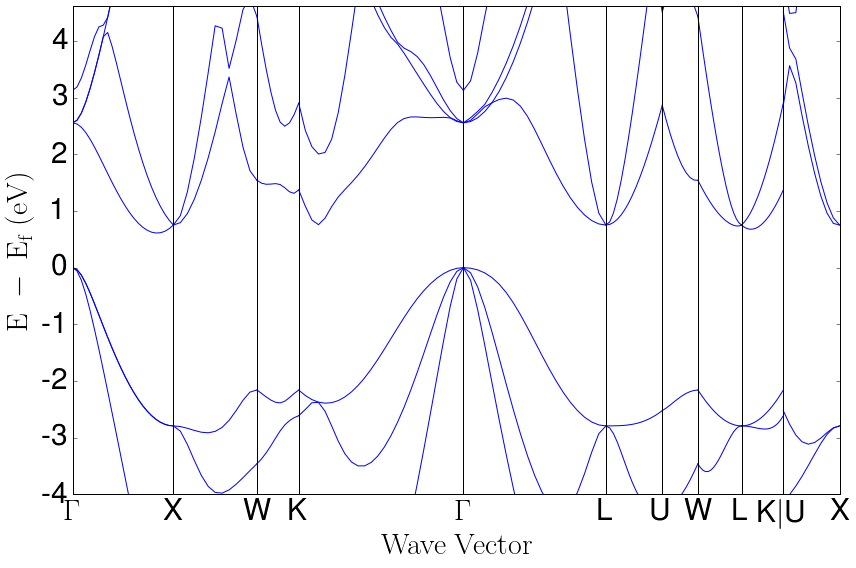

In [14]:
%matplotlib inline

from pymatgen.electronic_structure.plotter import BSPlotter

bs_plotter = BSPlotter(bs)
bs_plotter.show()

# Get Density of States

In [15]:
dos = get_dos(db_file)

# Plot Density of States

/home/matk/Software/eg_dev/venv_eg_dev/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


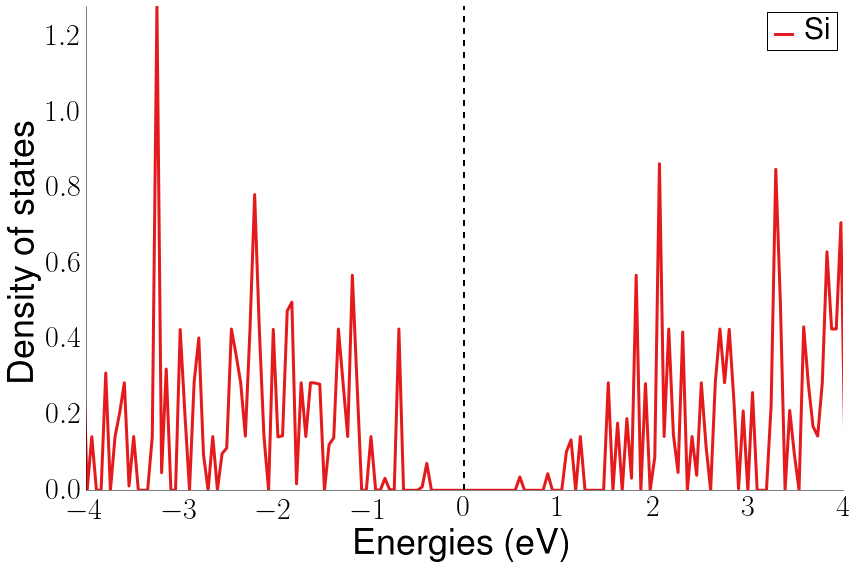

In [16]:
from pymatgen.electronic_structure.plotter import DosPlotter

dos_plotter = DosPlotter()
dos_plotter.add_dos("Si", dos)
dos_plotter.show(xlim=[-4,4])